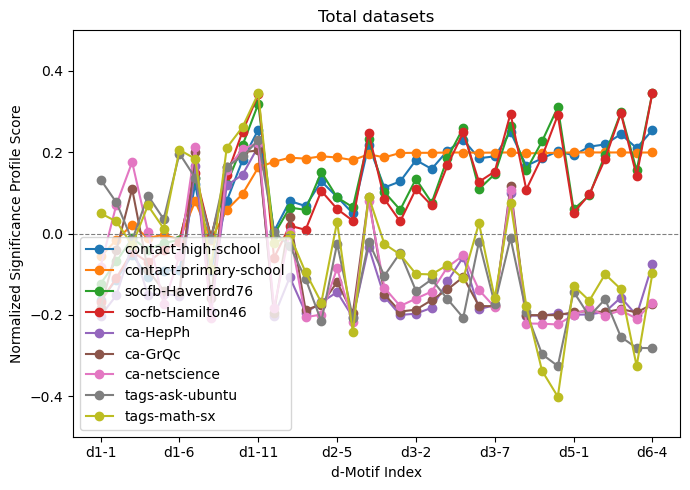

,0,1,2,3,4,5,6,7,8
0,1.000000,0.866819,0.884703,0.877967,0.210239,0.030709,-0.088946,-0.512574,-0.239629
1,0.866819,1.000000,0.662841,0.604999,-0.141962,-0.262881,-0.380855,-0.672666,-0.461280
2,0.884703,0.662841,1.000000,0.986531,0.377975,0.169989,0.047766,-0.423603,-0.147776
3,0.877967,0.604999,0.986531,1.000000,0.459558,0.250646,0.129582,-0.327498,-0.047469
4,0.210239,-0.141962,0.377975,0.459558,1.000000,0.937787,0.887975,0.570678,0.721219
5,0.030709,-0.262881,0.169989,0.250646,0.937787,1.000000,0.961005,0.658890,0.741412
6,-0.088946,-0.380855,0.047766,0.129582,0.887975,0.961005,1.000000,0.736871,0.800350
7,-0.512574,-0.672666,-0.423603,-0.327498,0.570678,0.658890,0.736871,1.000000,0.927125
8,-0.239629,-0.461280,-0.147776,-0.047469,0.721219,0.741412,0.800350,0.927125,1.000000


In [128]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('./extend_output/output.json') as f:
    real = json.load(f)

with open('./extend_output/random_output.json') as f:
    random = json.load(f)

# Extract the domain name
domain = 'Total'
sorted_keys = ['4-1-1', '4-1-2', '4-1-3', '4-1-4', '4-1-5', '4-1-6', '4-1-7', '4-1-8', '4-1-9', '4-1-10', '4-1-11',
               '4-2-1', '4-2-2', '4-2-3', '4-2-4', '4-2-5', '4-2-6', '4-2-7', '4-2-8',
               '4-3-1', '4-3-2', '4-3-3', '4-3-4', '4-3-5', '4-3-6', '4-3-7', '4-3-8',
               '4-4-1', '4-4-2', '4-4-3', 
               '4-5-1', '4-5-2', 
               '4-6-1', '4-6-2', '4-6-3', '4-6-4']

labels = ['d1-1', 'd1-2', 'd1-3', 'd1-4', 'd1-5', 'd1-6', 'd1-7', 'd1-8', 'd1-9', 'd1-10', 'd1-11',
               'd2-1', 'd2-2', 'd2-3', 'd2-4', 'd2-5', 'd2-6', 'd2-7', 'd2-8',
               'd3-1', 'd3-2', 'd3-3', 'd3-4', 'd3-5', 'd3-6', 'd3-7', 'd3-8',
               'd4-1', 'd4-2', 'd4-3', 
               'd5-1', 'd5-2', 
               'd6-1', 'd6-2', 'd6-3', 'd6-4']
srp_data = []

# Define domain groups
domains = {
    'contact': [5, 6],
    'socfb' : [9, 10],
    'collaboration': [0, 1, 2],
    'tags' : [7, 8]
}
dataset_order= {}
for keys in domains:
    dataset_order[keys] = []
    

# Prepare for plotting
plt.figure(figsize=(7, 5))

index = 0
for group_name, indices in domains.items():
    for i in indices:
        real_data = real[i]
        random_data = random[i]

        dataset = real_data["dataset"]
        dataset_order[group_name].append(index)
        index += 1

        # Remove the dataset name from the data
        del real_data["dataset"]
        del random_data["dataset"]

        # Compute Delta_i for each subgraph
        epsilon = 4
        delta_i = {}
        for key in list(real_data.keys()):
            N_real_i = real_data[key]
            N_rand_i = random_data[key]
            delta_i[key] = (N_real_i - N_rand_i) / (N_real_i + N_rand_i + epsilon)

        # Normalize Delta_i to get SRP_i
        sum_delta_squared = sum([delta**2 for delta in delta_i.values()])
        srp_i = {key: delta / np.sqrt(sum_delta_squared) for key, delta in delta_i.items()}

        # Sort SRP_i by subgraph keys
        sorted_srp_i = [srp_i[key] for key in sorted_keys]
        srp_data.append(sorted_srp_i)

        # Plot the Subgraph Ratio Profile
        plt.plot(sorted_keys, sorted_srp_i, marker='o', label=f'{dataset}')

df = pd.DataFrame(srp_data).T
correlation_matrix = df.corr(method='pearson')

# Plot settings
plt.xlabel('d-Motif Index')
plt.ylabel('Normalized Significance Profile Score')
plt.title(f'{domain} datasets')
plt.ylim(-0.5, 0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()

num_labels_to_show = 8
step = len(labels) // (num_labels_to_show - 1)
visible_positions = list(range(0, len(labels), step))[:num_labels_to_show]
visible_labels = [labels[i] for i in visible_positions]
plt.xticks(visible_positions, visible_labels)


# Save the plot
filename = f'{domain}_extend.png'
plt.savefig(f'./figure/{filename}')

# Display the plot
plt.show()
correlation_matrix

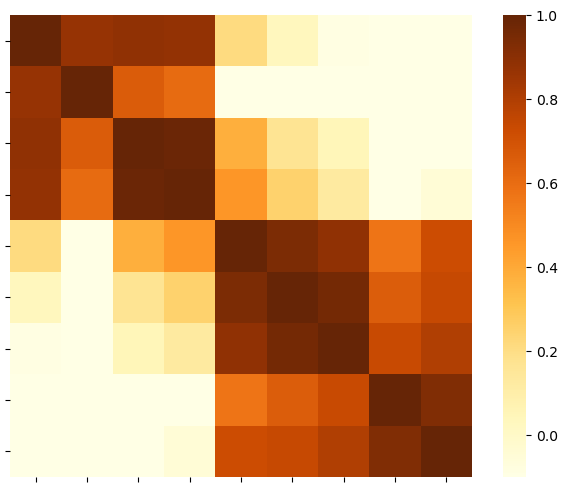

In [129]:
import seaborn as sns

labels = ['CONTACT', 'CONTACT', 'SOCFB', 'SOCFB', 'CA', 'CA', 'CA', 'TAGS', 'TAGS']
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='YlOrBr', cbar=True, square=True, vmin=-0.1, vmax=1)
# plt.title('Correlation Coefficient Matrix')
# plt.xlabel('Datasets')
# plt.ylabel('Datasets')
# Add custom colored labels
ax = plt.gca()
#ax.set_xticks(np.arange(len(labels)) + 0.5)
#ax.set_yticks(np.arange(len(labels)) + 0.5)
#ax.set_xticklabels(labels, rotation=90, ha='right', rotation_mode='anchor')
#ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels([''] * len(labels))
ax.set_yticklabels([''] * len(labels))
plt.show()

#0.78 vs 0.70 #contact 제외한것도 설명

In [130]:
def calculate_average_correlations(correlation_matrix, domain_indices):
    domain_intra_corr = {}
    domain_inter_corr = {}
    intra_domain_corr = []
    inter_domain_corr = []

    for domain1, indices1 in domain_indices.items():
        for domain2, indices2 in domain_indices.items():
            corrs = correlation_matrix.loc[indices1, indices2].values.flatten()
            if domain1 == domain2:
                corrs = [corr for corr in corrs if corr != 1.0]
                mean_corr = np.mean(corrs)
                domain_intra_corr[(domain1, domain2)] = mean_corr
                intra_domain_corr.extend(corrs)
            else:
                mean_corr = np.mean(corrs)
                domain_inter_corr[(domain1, domain2)] = mean_corr
                inter_domain_corr.extend(corrs)

    average_intra_domain_corr = np.mean(intra_domain_corr) 
    average_inter_domain_corr = np.mean(inter_domain_corr)

    return domain_intra_corr, domain_inter_corr, average_intra_domain_corr, average_inter_domain_corr

# 도메인 별 유사도 계산
domains_indices = {
    'contact': [0, 1],
    'socfb' : [2, 3],
    'collaboration': [4, 5, 6],
    'tags' : [7, 8]
}

domain_intra_corr, domain_inter_corr, average_intra_domain_corr, average_inter_domain_corr = calculate_average_correlations(correlation_matrix, domains_indices)

# 도메인 별 유사도 출력
print("Domain intra-correlations:")
for domains, corr in domain_intra_corr.items():
    print(f'{domains}: {corr:.4f}')

print("\nDomain inter-correlations:")
for domains, corr in domain_inter_corr.items():
    print(f'{domains}: {corr:.4f}')

# 평균 intra-domain 및 inter-domain 유사도 출력
print(f'\nAverage intra-domain correlation: {average_intra_domain_corr:.4f}')
print(f'Average inter-domain correlation: {average_inter_domain_corr:.4f}')


Domain intra-correlations:
('contact', 'contact'): 0.8668
('socfb', 'socfb'): 0.9865
('collaboration', 'collaboration'): 0.9289
('tags', 'tags'): 0.9271

Domain inter-correlations:
('contact', 'socfb'): 0.7576
('contact', 'collaboration'): -0.1056
('contact', 'tags'): -0.4715
('socfb', 'contact'): 0.7576
('socfb', 'collaboration'): 0.2393
('socfb', 'tags'): -0.2366
('collaboration', 'contact'): -0.1056
('collaboration', 'socfb'): 0.2393
('collaboration', 'tags'): 0.7049
('tags', 'contact'): -0.4715
('tags', 'socfb'): -0.2366
('tags', 'collaboration'): 0.7049

Average intra-domain correlation: 0.9279
Average inter-domain correlation: 0.1743


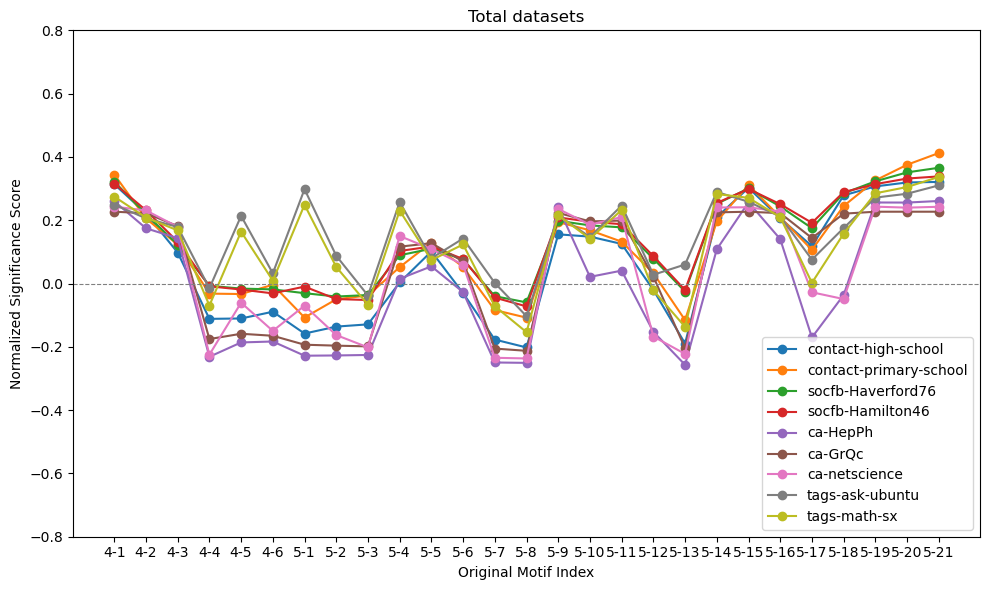

,0,1,2,3,4,5,6,7,8
0,1.000000,0.983325,0.988913,0.988123,0.910417,0.940353,0.862236,0.692013,0.775925
1,0.983325,1.000000,0.982014,0.968854,0.925090,0.897986,0.846917,0.679634,0.775037
2,0.988913,0.982014,1.000000,0.996539,0.899287,0.925976,0.846622,0.708853,0.774261
3,0.988123,0.968854,0.996539,1.000000,0.896398,0.944746,0.860093,0.723363,0.780901
4,0.910417,0.925090,0.899287,0.896398,1.000000,0.896293,0.944283,0.738034,0.824771
5,0.940353,0.897986,0.925976,0.944746,0.896293,1.000000,0.909970,0.680629,0.752171
6,0.862236,0.846917,0.846622,0.860093,0.944283,0.909970,1.000000,0.823279,0.884026
7,0.692013,0.679634,0.708853,0.723363,0.738034,0.680629,0.823279,1.000000,0.966136
8,0.775925,0.775037,0.774261,0.780901,0.824771,0.752171,0.884026,0.966136,1.000000


In [122]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('./original_output/output.json') as f:
    real = json.load(f)

with open('./original_output/random_output.json') as f:
    random = json.load(f)

# Extract the domain name
domain = 'Total'
#sorted_keys = ['4-1', '4-2', '4-3', '4-4', '4-5', '4-6']

#sorted_keys = ['5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '5-14', '5-15', '5-16', '5-17', '5-18', '5-19', '5-20', '5-21']

sorted_keys = ['4-1', '4-2', '4-3', '4-4', '4-5', '4-6', '5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '5-14', '5-15', '5-16', '5-17', '5-18', '5-19', '5-20', '5-21']
srp_data = []

# Define domain groups
domains = {
    'contact': [5, 6],
    'socfb' : [9, 10],
    'collaboration': [0, 1, 2],
    'tags' : [7, 8]
}
daset_order= {}
for keys in domains:
    dataset_order[keys] = []
    

# Prepare for plotting
plt.figure(figsize=(10, 6))

index = 0
for group_name, indices in domains.items():
    for i in indices:
        real_data = real[i]
        random_data = random[i]

        dataset = real_data["dataset"]
        dataset_order[group_name].append(index)
        index += 1

        # Remove the dataset name from the data
        del real_data["dataset"]
        del random_data["dataset"]

        # Compute Delta_i for each subgraph
        epsilon = 4
        delta_i = {}
        for key in list(real_data.keys()):
            N_real_i = real_data[key]
            N_rand_i = random_data[key]
            delta_i[key] = (N_real_i - N_rand_i) / (N_real_i + N_rand_i + epsilon)

        # Normalize Delta_i to get SRP_i
        sum_delta_squared = sum([delta**2 for delta in delta_i.values()])
        srp_i = {key: delta / np.sqrt(sum_delta_squared) for key, delta in delta_i.items()}

        # Sort SRP_i by subgraph keys
        sorted_srp_i = [srp_i[key] for key in sorted_keys]
        srp_data.append(sorted_srp_i)

        # Plot the Subgraph Ratio Profile
        plt.plot(sorted_keys, sorted_srp_i, marker='o', label=f'{dataset}')

df = pd.DataFrame(srp_data).T
correlation_matrix = df.corr(method='pearson')

# Plot settings
plt.xlabel('Original Motif Index')
plt.ylabel('Normalized Significance Score')
plt.title(f'{domain} datasets')
plt.ylim(-0.8, 0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()

# Save the plot
filename = f'{domain}_original4+5.png'
plt.savefig(f'./figure/{filename}')

# Display the plot
plt.show()
correlation_matrix


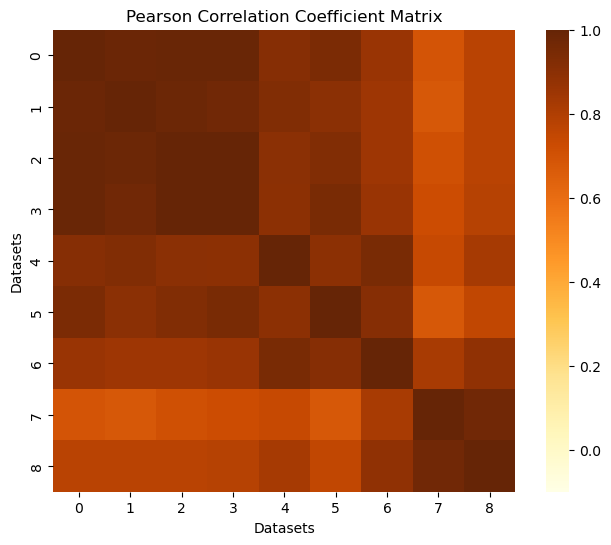

In [125]:
import seaborn as sns

labels = ['CONTACT', 'CONTACT', 'SOCFB', 'SOCFB', 'CA', 'CA', 'CA', 'TAGS', 'TAGS']
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='YlOrBr', cbar=True, square=True, vmin=-0.1, vmax=1)
plt.title('Pearson Correlation Coefficient Matrix')
plt.xlabel('Datasets')
plt.ylabel('Datasets')
# Add custom colored labels
ax = plt.gca()
# ax.set_xticks(np.arange(len(labels)) + 0.5)
# ax.set_yticks(np.arange(len(labels)) + 0.5)
# ax.set_xticklabels(labels, rotation=90, ha='right', rotation_mode='anchor')
# ax.set_yticklabels(labels, rotation=0)
plt.show()

In [99]:
def calculate_average_correlations(correlation_matrix, domain_indices):
    domain_intra_corr = {}
    domain_inter_corr = {}
    intra_domain_corr = []
    inter_domain_corr = []

    for domain1, indices1 in domain_indices.items():
        for domain2, indices2 in domain_indices.items():
            corrs = correlation_matrix.loc[indices1, indices2].values.flatten()
            if domain1 == domain2:
                corrs = [corr for corr in corrs if corr != 1.0]
                mean_corr = np.mean(corrs)
                domain_intra_corr[(domain1, domain2)] = mean_corr
                intra_domain_corr.extend(corrs)
            else:
                mean_corr = np.mean(corrs)
                domain_inter_corr[(domain1, domain2)] = mean_corr
                inter_domain_corr.extend(corrs)

    print(intra_domain_corr)
    print(inter_domain_corr)
    average_intra_domain_corr = np.mean(intra_domain_corr) 
    average_inter_domain_corr = np.mean(inter_domain_corr)

    return domain_intra_corr, domain_inter_corr, average_intra_domain_corr, average_inter_domain_corr

# 도메인 별 유사도 계산
domains_indices = {
    'contact': [0, 1],
    'socfb' : [2, 3],
    'collaboration': [4, 5, 6],
    'tags' : [7, 8]
}

domain_intra_corr, domain_inter_corr, average_intra_domain_corr, average_inter_domain_corr = calculate_average_correlations(correlation_matrix, domains_indices)

# 도메인 별 유사도 출력
print("Domain intra-correlations:")
for domains, corr in domain_intra_corr.items():
    print(f'{domains}: {corr:.4f}')

print("\nDomain inter-correlations:")
for domains, corr in domain_inter_corr.items():
    print(f'{domains}: {corr:.4f}')

# 평균 intra-domain 및 inter-domain 유사도 출력
print(f'\nAverage intra-domain correlation: {average_intra_domain_corr:.4f}')
print(f'Average inter-domain correlation: {average_inter_domain_corr:.4f}')


[0.9833249845024693, 0.9833249845024693, 0.9965387402785034, 0.9965387402785034, 0.8962929847539683, 0.9442832627488503, 0.8962929847539683, 0.9099702897582834, 0.9442832627488503, 0.9099702897582834, 0.966136237260661, 0.966136237260661]
[0.9889129942915723, 0.9881228180293854, 0.9820140484083897, 0.9688541133879356, 0.9104166276729153, 0.9403533244738363, 0.8622360872381933, 0.9250904294842052, 0.897985826799347, 0.8469172165381801, 0.6920133343923601, 0.7759247701877341, 0.6796335286240126, 0.775036962331901, 0.9889129942915723, 0.9820140484083897, 0.9881228180293854, 0.9688541133879356, 0.8992872162773778, 0.9259757962806012, 0.8466221143185492, 0.89639839651278, 0.9447458276088913, 0.8600929815329359, 0.7088530239908529, 0.7742608141140677, 0.7233633842783385, 0.7809013609266744, 0.9104166276729153, 0.9250904294842052, 0.9403533244738363, 0.897985826799347, 0.8622360872381933, 0.8469172165381801, 0.8992872162773778, 0.89639839651278, 0.9259757962806012, 0.9447458276088913, 0.84662

4 :  0.98 0.87

5 :  0.95 0.84

4+5 : 0.96 0.84